# Seq2Seq Translation with Attention

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A second things that might help is to use a bidirectional model for the encoder. We set the `bidrectional` parameter to `True` for our GRU encoder, and double the number of inputs to the linear output layer of the encoder.

Also, we now need to set our hidden state:

```
hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))
```

### Code to re-run from start

In [1]:
import fastai
from fastai.text import *
print(fastai.__version__)

1.0.60


In [2]:
path = Config().data_path()

In [3]:
path = Config().data_path()/'giga-nah'

In [4]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [5]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [6]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [8]:
data = load_data('/Volumes/iKhalil/NMT/RNN/JW/Sentence/nch/0.376264/', 'JW_Sentence_data.pkl')
data

Seq2SeqDataBunch;

Train: LabelList (26839 items)
x: Seq2SeqTextList
▁xxbos ▁toueue,▁xxbos ▁amo ▁ma ▁timoiljuikaj ▁kej ▁maseualmej ▁moiljuiaj,▁xxbos ▁ximomokuitlaui kaj,▁xxbos ▁para ▁axaka ▁inmech kajkayauas ▁ika ▁miak ▁tlajtoli ▁yejyektsitsij ▁uan ▁kej a ▁nopa ▁inmech ilpi s ▁ipan ▁tlen ▁axmelauak ▁uan ▁tlen ▁axipati,▁xxbos ▁uikatl
y: TextList
xxbos cónyuge,xxbos no pensamos como la gente piensa,xxbos cuidado,xxbos quizás haya alguien que se los lleve como presa suya mediante la filosofía y el vano engaño del mundo,xxbos canciones
Path: /Users/ikhalil/.fastai/data/giga-nah;

Valid: LabelList (6713 items)
x: Seq2SeqTextList
▁xxbos ▁kema ▁tlajtolmoyaua yaya ▁kinmatiltik ▁maseualmej ▁kenijkatsa ▁kintsontlamilti skiaj ▁katli ▁amo ▁kualmej,▁xxbos ▁¿ kenijkatsa ▁tijchijkej ▁tlaj ▁amo ▁tijpia yayaj ▁tomij ?,▁xxbos ▁uikatl ▁teotsij ▁mitsmokuitlauis,▁xxbos ▁ya ▁amo ▁moiljuik ▁tlaj ▁kiampa ▁ki nankiliskia ▁ya ▁kinankilik,▁xxbos ▁ikniuaj ▁katli ▁inmech tekimakatokej ▁xijchiuakaj ▁kej ▁ya
y: Text

In [8]:
model_path = Config().model_path()

In [9]:
#Nah -> esp
emb_enc = torch.load(model_path/'nah_sentencex2_emb_JW.pth')
emb_dec = torch.load(model_path/'es_sentencex2_emb_JW.pth')

In [10]:
#Esp -> nah
emb_enc = torch.load(model_path/'es_sentence_emb_JW_es.pth')
emb_dec = torch.load(model_path/'nah_sentence_emb_JW_es.pth')

In [9]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [10]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [11]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [12]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [13]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [14]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [15]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [16]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

### Bidireccional

In [17]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

```
hid=torch.Size([2, 64, 300])
dec_inp=torch.Size([64])
enc_att=torch.Size([64, 30, 300])
hid_att=torch.Size([64, 300])
u=torch.Size([64, 30, 300])
attn_wgts=torch.Size([64, 30])
enc_out=torch.Size([64, 30, 512])
ctx=torch.Size([64, 512])
emb=torch.Size([64, 300])
```

In [18]:
xb,yb = next(iter(data.valid_dl))
xb.shape

torch.Size([64, 100])

In [20]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 100)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))
model.train()
model

Seq2SeqRNN_attn(
  (emb_enc): Embedding(1064, 300, padding_idx=1)
  (emb_dec): Embedding(8000, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (out_enc): Linear(in_features=512, out_features=300, bias=False)
  (gru_dec): GRU(812, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=8000, bias=True)
  (enc_att): Linear(in_features=512, out_features=300, bias=False)
  (hid_att): Linear(in_features=300, out_features=300, bias=True)
)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.32E-03


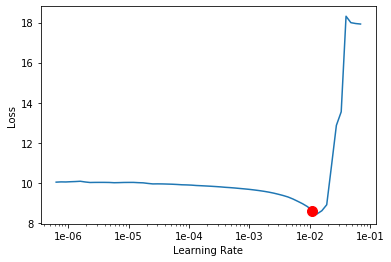

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(15, 3e-3)
#learn.fit_one_cycle(10, 5.75E-02)#, div_factor=5)

In [170]:
model.train()
learn.fit_one_cycle(1, 9.12E-04, div_factor=10)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.239378,5.615880,0.453116,0.375489,19:24


In [171]:
inputs, targets, outputs = get_predictions(learn)

In [172]:
inputs[10], targets[10], outputs[10]

(Text ▁xxbos ▁¿ kenke ▁tlauel ▁moneki ▁timo echkapantlalisej ? ▁pampa ▁kej ▁kiijtok ▁ya ▁kiampa ▁tijyolpakiltiaj ▁toteotsij ▁nopa ▁amochtli ▁ ven ▁ s é ▁mi ▁ s eguido r ▁kiijtoua ▁kema ▁se ▁maseuali ▁tlauel ▁moueyimati ▁eli ▁kej uak ▁kipixto skia ▁se ▁tlamantli ▁tlen ▁tlauel ▁kitlanaui a ▁pampa ▁moueyimati ▁toteotsij ▁amo ▁kitekiuia ▁yon ▁se ▁kentsi ▁ maske ▁ueli ▁kichiua ▁miak ▁tlamantli ▁uan ▁kema ▁se ▁maseuali ▁moechkapantlali a ▁toteotsij ▁tlauel ▁kitekiuia ▁ maske ▁nopa ▁maseuali ▁nesi ▁amo ▁tleno ▁ipati ▁uan ▁nojkia ▁kiijtoua ▁toteotsij ▁tlauel ▁techteochiuas ▁tlaj ▁nojkia ▁tijnextisej ▁nopa ▁kuali ▁tlamantli ▁nochi ▁tojuantij ▁tijmatij ▁tlauel ▁ipati ▁ tijyolpakiltisej ▁toteotsij ▁toteotsij,
 Text xxbos la razón más importante para tener humildad es que eso agrada a dios como dejó claro él con relación a estas palabras el libro ven sé mi seguidor dice el orgullo es un veneno sumamente xxunk este defecto hace que hasta la persona más capaz sea xxunk para dios la humildad por otro

In [173]:
inputs[909], targets[909], outputs[909]

(Text ▁xxbos ▁uajka ▁tlaj ▁eli ▁san ▁se ▁istlakatili ▁kema ▁kiijtouaj ▁tijpiaj ▁se ▁alma ▁tlen ▁noju a ▁yoltok ▁kema ▁timikij ▁¿ tlake ▁techpano ▁kema ▁timikij ?,
 Text xxbos entonces si la enseñanza sobre la inmortalidad del alma se basa en una mentira ¿ qué sucede al morir ?,
 Text xxbos ahora bien si es cierto que la muerte es un enemigo que xxunk la muerte ¿ qué hace cuando alguien nos xxunk ?)

In [174]:
inputs[1500], targets[1500], outputs[1500]

(Text ▁xxbos ▁tetajmej ▁moneki ▁kim a jtosej ▁kej ▁kitlalnamikti sej ▁ininkone ▁uelis ▁kichiuas ▁noju a ▁ma ▁kitekipano ▁teotsij ▁o ▁ma ▁kitlauelkaua,
 Text xxbos los padres deben darse cuenta de que su reacción puede influir en si su hijo seguirá sirviendo a dios o no,
 Text xxbos los padres deben tener la mente de que sus hijos se xxunk de que dios sea su propio tiempo)

In [110]:
learn.model.eval();
learn.export('JW_Sentence.pkl')
learn.save('JW_Sentence')

In [90]:
def convertToTensor(phrase):
    arrayT = []
    arrayT.append(data.x.vocab.stoi["xxbos"])
    for word in phrase.split():
        token = data.x.vocab.stoi[word]
        arrayT.append(token)
    return torch.tensor([arrayT])

In [338]:
paht = "/Volumes/iKhalil 64G/NMT/RNN/Axolotl/Spacy/spa/0.322177/"
data = load_data(paht, 'Axolotl_Spaicy_es_data.pkl')
learn = load_learner(paht,'Axolotl_Spaicy_es.pkl')
learn.model.eval();
sentences = []
for s in data.valid_ds:
    txt = s[0].text
    txt = txt.replace('xxbos ', '')
    sentences.append(txt)
sentences[0:5]

['in se xxunk las comidas sólo se usan una o dos ramitas',
 'respuesta con que la hija así contesta a su madre y le agradece su plática su enseñanza',
 'esta cilcuetzin matlaltzin se casó en tecuanipan pues la tomó por mujer tziuhtecatzin tzompahuacateuctli tlatohuani de tzompahuacan allá en tecuanipan dejó descendencia esta matlaltzin según lo refiere una tradición o xxunk de los chichimecas tenancas',
 'es frío',
 'ayocuantzin chichimecateuctli y cohuazacatzin teohuateuctli tlatoque de amaquemecan huyeron a huexotzinco cuauhtlehuanitzin tlailotlacteuctli y popocatzin atlauhtecatlteuctli tlatoque de tenanco también huyeron a huexotzinco quetzaltototzin tlatohuani de tecuanipan huyó a huexotzinco y asimismo teuctlacozauhcatzin tlamaocatlteuctli tlatohuani de panohuayan']

In [ ]:
new_sentences = list()

i = 0
for sentence in sentences:
    test = learn.model(convertToTensor(sentence.lower()))
    outputs = []
    for z in zip(test):
        outputs.append(
            learn.data.train_ds.y.reconstruct(
                z[0].argmax(1)
            )
        )
    new_sentences.append(outputs)
    if i < 5:
        print(outputs)
    i+=1

In [340]:
target_s = []
for ss in new_sentences:
    txt = ss[0].text
    txt = txt.replace('xxbos ', '')
    target_s.append(txt)
target_s[0:5]

['se se se xxunk xxunk se xxunk',
 'tlananquililiztli in ic ic quinanquilia in tlahtohuani in oquitlapalo',
 'ynin tlacatl yn ompa yn ompa tlacatl yn ompa yn yn ompa yn yn ompa yn chichimeca yn chichimeca yn ompa yn yn ompa quahuitzatzin yn ompa yn yn cihuapilli yn ompa yn yn atenco yn ipan yn ipan xihuitl yn ipan xihuitl',
 'in sesek',
 'yn çano yn itepeual yn huexotzinco ytoca quauhcececuitzin ytoca itoca uan huexotzinco ytoca itoca uan huexotzinco uan panohuayan ytoca tlatoani hualyetia michhuacan yn panohuayan ytoca chalco yn itoca ytoca ytzcahuacan yn mexica']